In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import common_functions as cf
import keras_tuner as kt

# from keras import models
# from keras import layers

In [2]:
# from tensorflow.python.client import device_lib
# print(device_lib.list_local_devices())
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


# CNN

In [3]:
def MakeModel(class_names: list) -> tf.keras.Sequential:
    """
    Simple straight forward CNN model. this is just for simplicity and testing
    atm. I will make it more modular later once I know what we are doing

    Args:
        class_names: list of the classification names
        conv_layers: list of how many filters each convolutional layer should use
        layers: list with the sizes of each hidden layer
    
    Returns:
        `tf.keras.Sequential` - a constructed tf model
    """
    tf.keras.backend.clear_session()
# tf.keras.regularizers.L2(hp.Choice("conv_regularizer", values=[1e-2, 1e-3, 1e-4]))
    def build_model(hp):
        model = tf.keras.Sequential()
        model.add(tf.keras.layers.Rescaling(1./255))
        for _ in range(1, hp.Int("num_conv_layers", 1, 2)):
            model.add(tf.keras.layers.Conv2D(hp.Int("conv_filters", 16, 28, 7), 3, kernel_regularizer='l2', activation='relu'))
            model.add(tf.keras.layers.MaxPooling2D())
        model.add(tf.keras.layers.Flatten())
        for _ in range(1, hp.Int("num_layers", 0, 5)):
            model.add(tf.keras.layers.Dense(hp.Int("units", 32, 512, 32), kernel_regularizer='l2', activation='relu'))
        model.add(tf.keras.layers.Dropout(rate=hp.Float("dropout", 0, 0.5, 0.1)))
        model.add(tf.keras.layers.Dense(len(class_names))) # output

        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=hp.Choice("learning_rate", values=[1e-2, 1e-3, 1e-4])),
            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            metrics=['accuracy']
        )

        return model
    
    return build_model

## Load Data

Found 12479 files belonging to 13 classes.
Found 4160 files belonging to 13 classes.
Found 4160 files belonging to 13 classes.


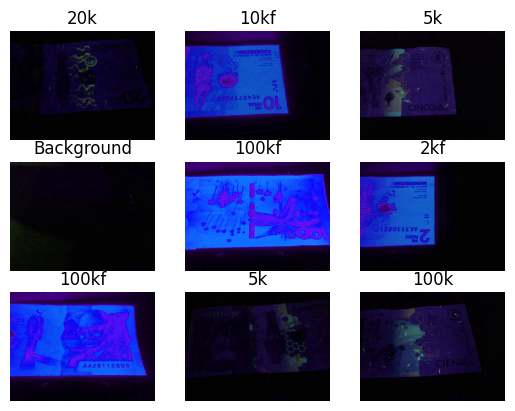

In [4]:
train_ds, test_ds, validation_ds, class_names = cf.LoadData(batch_size=16)
cf.PeakData(train_ds.map(cf.AugmentImage(hue=0.1)), class_names)

In [7]:
import random
from IPython.display import clear_output
import shutil
import time
from PIL import Image

def AugmentImages(src: str = "../Data/Original/ds1/", dest: str ="../Data/Augmented/", seed = None) -> None:
    if seed != None:
        random.seed(seed)
    if not os.path.exists(dest):
        os.mkdir(dest)

    print("Checking files if they need to be renamed to jpeg")
    for sub_folder in ["Train", "Test", "Validation"]:
        src_sub_path = src + sub_folder + "/"
        dest_sub_path = dest + sub_folder + "/"
        if not os.path.exists(dest_sub_path):
            os.mkdir(dest_sub_path)
        count = 0
        for img_folder in os.listdir(src_sub_path):
            src_img_path = src_sub_path + img_folder + "/"
            dest_img_path = dest_sub_path + img_folder + "/"
            if not os.path.exists(dest_img_path):
                os.mkdir(dest_img_path)
            num_files = len(os.listdir(src_img_path))
            for i, file_name in enumerate(os.listdir(src_img_path)):
                if count % 1000 == 0:
                    clear_output(wait=True)
                    print(f"{count} / {num_files} | {src_img_path} -> {dest_img_path}")
                    time.sleep(0.01)
                if file_name.endswith(".jpg"):
                    new_file_name = file_name.replace(".jpg", ".jpeg")
                    # image = Image.open(os.path.join(src_img_path, file_name))
                    # image.save(os.path.join(dest_img_path, new_file_name))
                    shutil.copy(os.path.join(src_img_path, file_name), os.path.join(dest_img_path, new_file_name))
                count += 1

    clear_output(wait=True)
    print("Running augments")
    time.sleep(0.5)
    for sub_folder in ["Train", "Test", "Validation"]:
        src_sub_path = src + sub_folder + "/"
        dest_sub_path = dest + sub_folder + "/"
        count = 0
        for img_folder in os.listdir(src_sub_path):
            dest_img_path = dest_sub_path + img_folder + "/"
            num_files = len(os.listdir(dest_img_path))
            for i, file_name in enumerate(os.listdir(dest_img_path)):
                if count % 1000 == 0:
                    clear_output(wait=True)
                    print(f"{count} / {num_files} | {dest_img_path}")
                data = tf.image.decode_jpeg(tf.io.read_file(dest_img_path + file_name))
                ([
                    lambda: data,
                    lambda: tf.image.random_hue(data,0.5,seed),
                    lambda: tf.image.random_brightness(data,0.8,seed),
                    lambda: tf.image.random_contrast(data,0.1,0.8,seed),
                    lambda: tf.image.random_saturation(data,0.1,0.8,seed)
                ])[((random.randomint(0,4) if seed != None else 0) + i) % 5]()
                tf.keras.utils.save_img(dest_img_path + file_name[:-4] + ".jpeg", data)
                count += 1
    print("Done")


In [8]:
AugmentImages()

1000 / 960 | ../Data/Augmented/Train/50k/
../Data/Augmented/Train/50k/632.jpeg
../Data/Augmented/Train/50k/1080.jpeg
../Data/Augmented/Train/50k/1068.jpeg
../Data/Augmented/Train/50k/1162.jpeg
../Data/Augmented/Train/50k/1128.jpeg
../Data/Augmented/Train/50k/564.jpeg
../Data/Augmented/Train/50k/660.jpeg
../Data/Augmented/Train/50k/1235.jpeg
../Data/Augmented/Train/50k/669.jpeg
../Data/Augmented/Train/50k/757.jpeg
../Data/Augmented/Train/50k/296.jpeg
../Data/Augmented/Train/50k/688.jpeg
../Data/Augmented/Train/50k/776.jpeg
../Data/Augmented/Train/50k/650.jpeg
../Data/Augmented/Train/50k/293.jpeg
../Data/Augmented/Train/50k/1515.jpeg
../Data/Augmented/Train/50k/107.jpeg
../Data/Augmented/Train/50k/282.jpeg
../Data/Augmented/Train/50k/349.jpeg
../Data/Augmented/Train/50k/1387.jpeg
../Data/Augmented/Train/50k/636.jpeg
../Data/Augmented/Train/50k/45.jpeg
../Data/Augmented/Train/50k/515.jpeg
../Data/Augmented/Train/50k/681.jpeg
../Data/Augmented/Train/50k/1388.jpeg
../Data/Augmented/Train/50

KeyboardInterrupt: 

In [41]:
tf.io.decode_image("/home/jovyan/work/MIDS/final-project/Colombian-peso-counterfeit-detection/Data/Train/5k/1237.jpeg")

InvalidArgumentError: {{function_node __wrapped__DecodeImage_device_/job:localhost/replica:0/task:0/device:CPU:0}} Unknown image file format. One of JPEG, PNG, GIF, BMP required. [Op:DecodeImage]

In [32]:
import random

def RandomlyAugmentImages(seed = None):
    """
    Preprocess function that chooses a random augment to apply to the image.
    The augment will also apply at a random delta for variation.
    Augments include hue, brightness, contrast, saturation, and nothing.

    Args:
        seed: if you need a consistant result you can set the seed here. `None` will not use a seed (None is the default)

    Return:
        Function to run the preprocess on
    """
    def AugmentHelper(x):
        print("HEREEEEEEEEEEEEEEEEEEEEE")
        print(x)
        if seed != None:
            random.seed(seed)
        # return random.choice([
        #     lambda: x,
        #     lambda: tf.image.random_hue(x,0.5,seed),
        #     lambda: tf.image.random_brightness(x,0.8,seed),
        #     lambda: tf.image.random_contrast(x,0.1,0.8,seed),
        #     lambda: tf.image.random_saturation(x,0.1,0.8,seed)
        # ])()
        return x #tf.image.random_hue(x[0].as_numpy_iterator(),0.5,seed)
    return AugmentHelper

HEREEEEEEEEEEEEEEEEEEEEE
<_BatchDataset element_spec=(TensorSpec(shape=(None, 480, 640, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


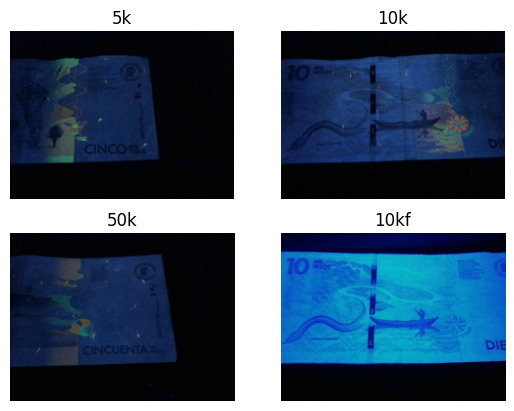

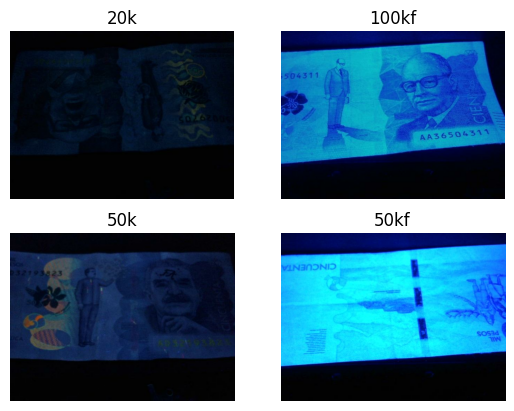

In [37]:
count = 0
for images, labels in train_ds.apply(RandomlyAugmentImages()):
    if count >= 2:
        break
    for i in range(2 * 2):
        plt.subplot(2, 2, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
    plt.show()
    count += 1

In [5]:
model = cf.CNNModel(class_names)
model.fit(
    train_ds.map(cf.RandomlyAugmentImages(123)),
    validation_data=validation_ds.map(cf.RandomlyAugmentImages(123))
)

 32/780 [>.............................] - ETA: 7:46 - loss: 67.3995 - accuracy: 0.1992

KeyboardInterrupt: 

# Run Hyperparameterization

In [5]:
tuner = kt.Hyperband(MakeModel(class_names),
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='hp_logs/cnn',
                     project_name='grayscale')
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
tuner.search(
    train_ds, 
    validation_data=validation_ds, 
    epochs=50, 
    callbacks=[stop_early]
)

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

INFO:tensorflow:Reloading Tuner from hp_logs/cnn/grayscale/tuner0.json
INFO:tensorflow:Oracle triggered exit

The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 512 and the optimal learning rate for the optimizer
is 0.0001.



# Find Best Epoch

In [6]:
# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
# .map(cf.AugmentImage(contrast=1))
model = tuner.hypermodel.build(best_hps)
history = model.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=10
)

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Epoch 1/10
390/390 [==============================] - 32s 67ms/step - loss: 1.2788 - accuracy: 0.5505 - val_loss: 0.8093 - val_accuracy: 0.7538
Epoch 2/10
390/390 [==============================] - 25s 64ms/step - loss: 0.5766 - accuracy: 0.8395 - val_loss: 0.4326 - val_accuracy: 0.8894
Epoch 3/10
390/390 [==============================] - 25s 64ms/step - loss: 0.3316 - accuracy: 0.9220 - val_loss: 0.3006 - val_accuracy: 0.9236
Epoch 4/10
390/390 [==============================] - 25s 64ms/step - loss: 0.2179 - accuracy: 0.9546 - val_loss: 0.1784 - val_accuracy: 0.9688
Epoch 5/10
390/390 [==============================] - 25s 64ms/step - loss: 0.1459 - accuracy: 0.9751 - val_loss: 0.1356 - val_accuracy: 0.9834
Epoch 6/10
390/390 [==============================] - 25s 64ms/step - loss: 0.1281 - accuracy: 0.9788 - val_loss: 0.1075 - val_accuracy: 0.9858
Epoch 7/10
390/390 [==============================] - 25s 64ms/step - loss: 0.0878 - accuracy: 0.9886 - val_loss: 0.1115 - val_accuracy:

# Fit the Best Model

In [10]:
hypermodel = tuner.hypermodel.build(best_hps)

# Retrain the model
hypermodel.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=best_epoch,
    validation_split=0.2
)

Epoch 1/9
390/390 [==============================] - 26s 64ms/step - loss: 1.3477 - accuracy: 0.5476 - val_loss: 0.8785 - val_accuracy: 0.7478
Epoch 2/9
390/390 [==============================] - 25s 64ms/step - loss: 0.5809 - accuracy: 0.8308 - val_loss: 0.5001 - val_accuracy: 0.8567
Epoch 3/9
390/390 [==============================] - 25s 64ms/step - loss: 0.3811 - accuracy: 0.9007 - val_loss: 0.3722 - val_accuracy: 0.8942
Epoch 4/9
390/390 [==============================] - 25s 64ms/step - loss: 0.2482 - accuracy: 0.9457 - val_loss: 0.2126 - val_accuracy: 0.9659
Epoch 5/9
390/390 [==============================] - 25s 64ms/step - loss: 0.1870 - accuracy: 0.9644 - val_loss: 0.2514 - val_accuracy: 0.9308
Epoch 6/9
390/390 [==============================] - 25s 64ms/step - loss: 0.1512 - accuracy: 0.9728 - val_loss: 0.1769 - val_accuracy: 0.9563
Epoch 7/9
390/390 [==============================] - 25s 63ms/step - loss: 0.1434 - accuracy: 0.9733 - val_loss: 0.1006 - val_accuracy: 0.9913

# Evaluate

In [11]:
eval_result = hypermodel.evaluate(test_ds)
print("[test loss, test accuracy]:", eval_result)

130/130 [==============================] - 4s 30ms/step - loss: 0.1522 - accuracy: 0.9596
[test loss, test accuracy]: [0.15219970047473907, 0.9596154093742371]


# Results

grayscale, no augmentation, hyperparameterized = 0.998 searched, 0.995 trained, 0.9957 test